### Logistic Regression 

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    )

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import encoding as ce
from feature_engine import discretisation as disc
from feature_engine import transformation as t


import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
df_feat =  pd.read_excel('feature_importance_catboost.xlsx')
drop_cols = df_feat[df_feat['PredictionValuesChange'] == 0]['Feature Id'] 

X.drop(columns= drop_cols, inplace= True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state= 42)

X_train.shape, X_test.shape

((107401, 126), (46029, 126))

In [5]:
df_summary =  summary_table(df_data)

# rm_columns_mis = df_summary[df_summary['Missing_Ratio'] > 0.75].Name

# X.drop(columns = rm_columns_mis, inplace = True)

Dataset Shape: (153430, 843)


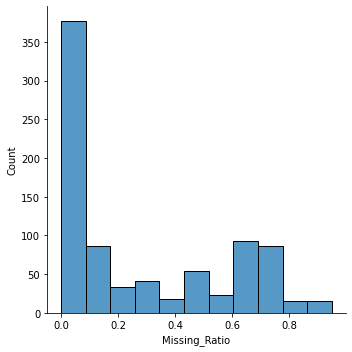

In [9]:
sns.displot(
    df_summary['Missing_Ratio'].sort_values(ascending=False)
) 

#### Set up the pipeline
* impute numerical variables
* scale all variables
* train a logistic regression

### Logistic Regression

In [64]:
from hyperopt import hp
from hyperopt import fmin, tpe, Trials
from hyperopt import STATUS_OK

DIR ='./'

# Domain space
space = {
    # 'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.loguniform('C', 0.001, 1.0),
}

def objective_function(params):

    logit_pipe = Pipeline([
        ('imputer', mdi.MeanMedianImputer(imputation_method='median')),
        ('scaler', StandardScaler(with_std= True)),
        ('logit', LogisticRegression(random_state= 43, penalty = 'l1', solver = 'saga', C = params['C']))
    ])

    cross_val = cross_val_score(
        logit_pipe, X_train, y_train, 
        cv = StratifiedKFold(n_splits= 5, shuffle =True), scoring ='roc_auc', n_jobs= 2
        )
        
    loss_mean = cross_val.mean()
    loss_std = cross_val.std()
    
    return {'loss': -loss_mean, 'loss_std': loss_std, 'status': STATUS_OK}

# Optimization algorithm
tpe_algorithm = tpe.suggest

# Result history 
trials = Trials()
num_eval = 100

best_params = fmin(
    objective_function, space, tpe.suggest, max_evals = num_eval, 
    trials = trials
    )

pickle.dump(trials, open(DIR + 'trial_results_v0_2.sav', 'wb'))

100%|██████████| 100/100 [1:39:09<00:00, 59.50s/trial, best loss: -0.7555586790453694]


In [ ]:
results = pd.DataFrame(search.cv_results_)

# we can order the different models based on their performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results[[
    'param_logit__C', 'param_logit__penalty', 'mean_test_score', 'std_test_score',
]].head()

,param_logit__C,param_logit__penalty,mean_test_score,std_test_score
0,0.001,l2,0.758656,0.003514
1,0.005,l2,0.758506,0.003685
2,0.01,l2,0.757998,0.003800
3,0.05,l2,0.756155,0.003948
4,0.1,l2,0.755463,0.003855


Text(0.5, 0, 'Hyperparameter combinations')

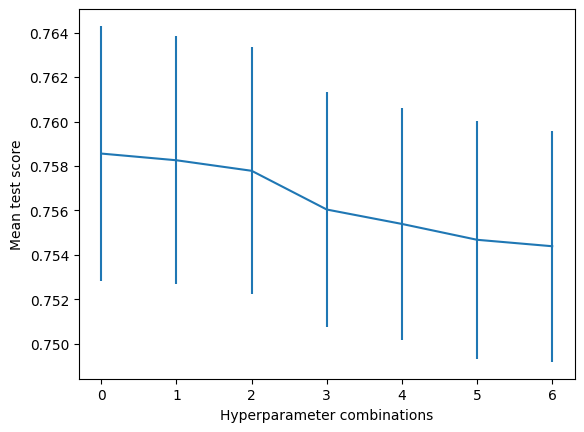

In [78]:

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [67]:
logit_pipe = Pipeline([
        ('imputer', mdi.MeanMedianImputer(imputation_method='median')),
        ('scaler', StandardScaler(with_std= True)),
        ('logit', LogisticRegression(random_state= 43, **best_params, penalty= 'l1', solver= 'saga'))
    ])

logit_pipe.fit(X_train, y_train)

X_train_preds = logit_pipe.predict_proba(X_train)[:,1]
X_test_preds = logit_pipe.predict_proba(X_test)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds))

/Users/witnes/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train roc_auc:  0.757718919831712
Test roc_auc:  0.7546107826243982


In [68]:

X_train_preds = logit_pipe.predict(X_train)
X_test_preds = logit_pipe.predict(X_test)

print('Train accuracy: ', balanced_accuracy_score(y_train, X_train_preds))
print('Test accuracy: ', balanced_accuracy_score(y_test, X_test_preds))

Train accuracy:  0.5087152266913367
Test accuracy:  0.5079186310699285


In [69]:
df_coef =pd.DataFrame(
    {
       'feature': X_train.columns, 
       'coef' : logit_pipe[2].coef_[0]
    }
).sort_values(by = 'coef')
#.to_csv('logit_coef.xlsx', index =False)